In [ ]:
 !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"l4e1owek","key":"a31d8529a9ceb19f66a1f35ce6044f83"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c ml-intensive-yandex-academy-spring-2024 -p data

100% 985M/988M [00:50<00:00, 23.3MB/s]
100% 988M/988M [00:50<00:00, 20.6MB/s]


In [ ]:
import zipfile
import os

# Путь к вашему архиву
zip_file_path = '/content/data/ml-intensive-yandex-academy-spring-2024.zip'

# Папка, куда вы хотите извлечь содержимое архива
extract_folder = '/content/data'

# Создаем папку для извлеченных файлов, если она еще не существует
os.makedirs(extract_folder, exist_ok=True)

# Разархивируем архив
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Архив успешно разархивирован.")

Архив успешно разархивирован.


In [1]:
from torch.utils.data import Dataset
import glob
from PIL import Image
import random as rnd
import pandas as pd
import numpy as np
import pickle
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

In [ ]:
# Взял у Максима

train_images_folder = "data/data/train_images"
image_paths = [os.path.join(train_images_folder, filename) for filename in os.listdir(train_images_folder)]
sum_pixels = np.zeros(3)
sum_squared_pixels = np.zeros(3)
count = 0

for image_path in tqdm(image_paths, desc="Нахождение значения Normalize", unit=" image"):
    img = Image.open(image_path).convert("RGB")
    img_array = np.array(img) / 255
    sum_pixels += np.sum(img_array, axis=(0, 1))
    sum_squared_pixels += np.sum(img_array ** 2, axis=(0, 1))
    count += img_array.shape[0] * img_array.shape[1]

mean = (sum_pixels / count)
std = np.sqrt((sum_squared_pixels / count) - (mean ** 2))
print("Mean:", mean)
print("Std:", std)

Нахождение значения Normalize: 100%|██████████| 27000/27000 [02:00<00:00, 223.46 image/s]

Mean: 0.5139462690121577
Std: 0.24807255906863065


In [ ]:
mean = [0.5139462690121602, 0.5139462690121602, 0.5139462690121602]
std = [0.24807255906862483, 0.24807255906862483, 0.24807255906862483]


In [ ]:
class CustomDataset(Dataset):
    def __init__(
        self,
        csv_file,
        root_dir,
        save_file=None,
        transform=None,
        mask_dir=None,
        have_mask=False,
    ):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.save_file = save_file
        self.transform = transform
        self.have_mask = have_mask
        self.mask_dir = mask_dir

        if not save_file:
            return

        if os.path.exists(self.save_file):
            with open(self.save_file, "rb") as f:
                self.data = pickle.load(f)
        else:
            self.data = []
            for idx in range(len(self.data_frame)):
                img_name = os.path.join(
                    self.root_dir, f"img_{self.data_frame.iloc[idx, 0]}.png"
                )
                image = Image.open(img_name)
                target = self.data_frame.iloc[idx, 1]

                if self.have_mask:
                    mask_name = os.path.join(
                        self.mask_dir, f"img_{self.data_frame.iloc[idx, 0]}.png"
                    )
                    mask = Image.open(mask_name)
                    image = Image.fromarray(
                        cv2.bitwise_and(
                            np.array(image), np.array(image), mask=np.array(mask)
                        )
                    )

                if self.transform:
                    image = self.transform(image)

                self.data.append((image, target))

            # Сохраняем данные в файл
            with open(self.save_file, "wb") as f:
                pickle.dump(self.data, f)

    def __len__(self):
        if self.save_file:
            return len(self.data)
        return len(self.data_frame)

    def __getitem__(self, idx):
        if self.save_file:
            return self.data[idx]

        img_name = os.path.join(self.root_dir, f"img_{self.data_frame.iloc[idx, 0]}.png")
        image = Image.open(img_name)
        target = self.data_frame.iloc[idx, 1]

        if self.have_mask:
            mask_name = os.path.join(self.mask_dir, f"img_{self.data_frame.iloc[idx, 0]}.png")
            mask = Image.open(mask_name)
            image = Image.fromarray(cv2.bitwise_and(np.array(image), np.array(image), mask=np.array(mask)))

        if self.transform:
            image = self.transform(image)

        return image, target

    def get_balance_data(self, augmentation_transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=45)
    ])):
        class_count = {}
        balance_data = []

        for i in range(len(self)):
            if self[i][1] not in class_count.keys():
                class_count[self[i][1]] = [1, [i]]
            else:
                class_count[self[i][1]] = [class_count[self[i][1]][0] + 1, class_count[self[i][1]][1] + [i]]
                balance_data.append(self[i])

        mx_count = max(class_count.items(), key=lambda x:x[1][0])

        for item in class_count.items():
            for _ in range(mx_count[1][0] - item[1][0]):
                x = rnd.choice(item[1][1])
                image = self[x][0]
                balance_data.append((augmentation_transform(image), self[x][1]))
        return balance_data


class TestDataClassifer:
    def __init__(self, model, image_folder, transform=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model
        self.model.eval()
        self.image_folder = image_folder
        self.transform = transform

    def load_images_and_predict(self):
        predictions = []
        image_paths = sorted([os.path.join(self.image_folder, file) for file in os.listdir(self.image_folder) if file.endswith(('png', 'jpg', 'jpeg'))])

        for image_path in image_paths:
            image = Image.open(image_path).convert('RGB')

            image = self.transform(image)
            image = image.unsqueeze(0).to(self.device)

            with torch.no_grad():
                output = self.model(image)
                _, predicted = torch.max(output, 1)
                predictions.append(predicted.item())

        return predictions

    def save_predictions_to_csv(self, predictions):
        data = {"id": list(range(len(predictions))), "target_feature": predictions}
        df = pd.DataFrame(data)
        df.to_csv("predictions.csv", index=False)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

csv_file = os.getcwd() + '/data/data/train_answers.csv'
root_dir = os.getcwd() + '/data/data/train_images'
mask_dir = os.getcwd() + '/data/data/train_lung_masks'
save_file = os.getcwd() + '/data/data/data.pkl'
test_dir = os.getcwd() + '/data/data/test_images'

train_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, have_mask=False, mask_dir=mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score
from tqdm import tqdm

class AdvancedChestCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedChestCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 14 * 14)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Инициализация модели, функции потерь и оптимизатора
model = AdvancedChestCNN(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AdvancedChestCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
losses = []

checkpoint_dir = '/content/drive/MyDrive/'

# Load checkpoint if it exists
try:
  checkpoint_path = max(glob.glob(os.path.join(checkpoint_dir, 'checkpoint_3c_Advance_model_epoch_*.pth')), key=os.path.getctime)
except:
  checkpoint_path = ''
print(checkpoint_path)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location = device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
else:
    start_epoch = 0

# Training loop with checkpointing
num_epochs = 40
for epoch in range(start_epoch, start_epoch + (num_epochs - start_epoch)):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Train Loss: {train_loss:.4f}")

    checkpoint_path = os.path.join('/content/drive/MyDrive', f'checkpoint_3c_Advance_model_epoch_{epoch+1}.pth')
    if not os.path.exists(checkpoint_path):
        with open(checkpoint_path, "w") as f:
            print(f'created{checkpoint_path}')
    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses
            }, checkpoint_path)

/content/drive/MyDrive/checkpoint_3c_Advance_model_epoch_27.pth


100%|██████████| 844/844 [02:41<00:00,  5.21it/s]


Epoch [28/67], Train Loss: 0.0709
created/content/drive/MyDrive/checkpoint_3c_Advance_model_epoch_28.pth


  0%|          | 0/844 [00:00<?, ?it/s]

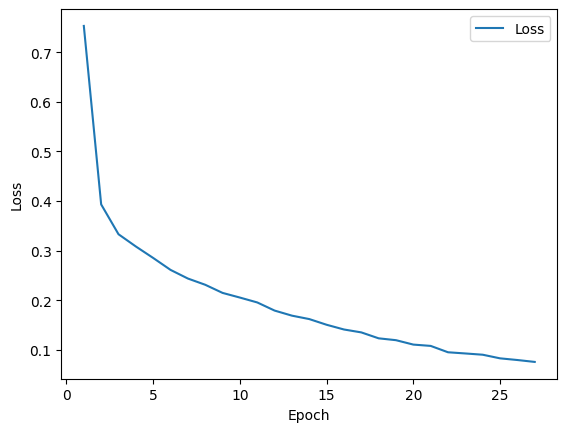

In [ ]:
plt.plot(range(1, num_epochs + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean, std)

])

classifier = TestDataClassifer(model, test_dir, transform)
predictions = classifier.load_images_and_predict()
classifier.save_predictions_to_csv(predictions)

In [ ]:

model.eval()
image = train_dataset[1][0]
with torch.no_grad():
    output = model(image.unsqueeze(0).to(device))
    print(torch.max(output, 1))

torch.return_types.max(
values=tensor([4.0809], device='cuda:0'),
indices=tensor([0], device='cuda:0'))
